<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Проект-для-«Викишоп»" data-toc-modified-id="Проект-для-«Викишоп»-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Проект для «Викишоп»</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Train-&amp;-test" data-toc-modified-id="Train-&amp;-test-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train &amp; test</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LightGBM-Classifier" data-toc-modified-id="LightGBM-Classifier-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>LightGBM Classifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Проект для «Викишоп»

__С использованием TF-IDF__

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 

Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Подготовка

In [2]:
#pip install pandarallel
#pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [16]:
# импортируем библиотеки
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import requests

from tqdm import notebook, tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
#nltk.download('all')
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import re 

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()

from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
import random

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\easym\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\easym\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
# загрузим датасет, преобразуем даты в индексы
try:
    data2 = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data2 = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [3]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data2.sample(10)

,text,toxic
133878,"""\n\nPschemp, Wikipedia's responsible for this...",0
135818,"Sorry, I forgot that we wish to fill half the ...",0
100516,More links for the historical maps \n\nMore an...,0
36344,"""\n\n Jesus's name \n\nHi, I appreciate all yo...",0
127800,Supplimentary question\nThere's a korean tilti...,0
100606,"""\n\n Semi-protected edit request on 13 Decemb...",0
63115,"""\n\n Kirby move. \n\nI am deeply disappointed...",0
110073,"""\n\nI now replaced """"flip flop"""" with """"flip-...",0
148146,That's fine! Thanks!,0
15982,"Edit request from Sublimehypocrisy, 17 Decembe...",0


Проценты классов:
0    89.84
1    10.16
Name: toxic, dtype: float64


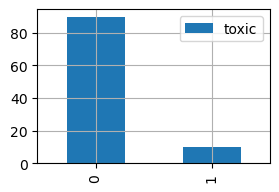

In [5]:
class_frequency = round((data2['toxic'].value_counts() / data2.shape[0]) * 100, 2)
print('Проценты классов:')
print(class_frequency)
class_frequency.plot(kind='bar', legend=True, figsize=(3,2), grid=True);

Наблюдения:
- Есть столбец `Unnamed: 0` - видимо, бывшие индексы. Его можно просто удалить.
- Столбец `toxic` - целевой признак, содержит два класса: `0` - не токсичный комментарий, `1` - токсичный. Заметен сильный дисбаланс классов, токсичных всего 10% всего датасета.


- Столбец `data['text']` - содержит фразы на английском. Следовательно нужен лемматизатор английского языка. Выберем NTLK. Импортируем.


### Лемматизация 
- прошлись по всем типам слов в англ. языке: _noun, adjective, verb, adverb_ (`'a', 's', 'r', 'n', 'v'`), т.е. глаголы, существительные и т.п. отдельно без тегов слов прекрасно справились
-  оставлены апострофы `'`
- обработаны сокращения типа _can't, I'd, I'm, you'll, you're_

Список сокращений:

<img src='https://englsecrets.ru/wp-content/uploads/2014/05/apostrophe1.jpg' width=500>

In [6]:
# лемматизация и очистка
# прошлись по всем типам слов в англ. языке: noun, adjective, verb, adverb ('a', 's', 'r', 'n', 'v'), 
# т.е. глаголы, существительные и т.п. отдельно без тегов слов прекрасно справились
# оставлены апострофы
# обработаны сокращения типа can't, I'd, I'm, you'll, you're

def lemmatize(text):
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    import nltk
    from nltk.corpus import wordnet
    
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    words = word_tokenize(text)
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(w, pos=get_wordnet_pos(w)) for w in words])


def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z\' ]', ' ', text).split()).lower().replace("can't", "can not").replace("'d", " had") \
                                                                .replace("'m", " am").replace("'s", " is").replace("'re", " are") \
                                                                .replace("'ll", " will").replace("'ve", " have") \
                                                                .replace("won't", "will not").replace("n't", " not") 
                                                                
                                                                
corpus = data2['text'].values

print("Исходный текст:", corpus[0])
print()
print("Очищенный текст:", lemmatize(clear_text(corpus[0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Очищенный текст: explanation why the edits make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after i vote at new york doll fac and please do not remove the template from the talk page since i be retire now


In [7]:
def lemmatize_my_old(text):
    words = word_tokenize(text)
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(w, pos="v") for w in words]
    words = [lem.lemmatize(w, pos="n") for w in words]
    words = [lem.lemmatize(w, pos="s") for w in words]
    words = [lem.lemmatize(w, pos="r") for w in words]
    return " ".join([lem.lemmatize(w, pos="a") for w in words])

print("Исходный текст:", corpus[0])
print()
print("Очищенный текст:", lemmatize_my_old(clear_text(corpus[0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Очищенный текст: explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after i vote at new york doll fac and please do not remove the template from the talk page since i be retire now


In [8]:
%%time
# лемматизация всего текста
#lem_corpus = []
#for i in notebook.tqdm(range(len(corpus))):
#    lem_corpus.append(lemmatize(clear_text(corpus[i])))
data2['lemm_text'] = data2['text'].progress_apply(clear_text)
data2['lemm_text'] = data2['lemm_text'].parallel_apply(lemmatize)

100%|██████████| 159292/159292 [00:02<00:00, 73855.83it/s]


Wall time: 23min 45s


In [9]:
%%time
# а теперь засечем время с моей функцией, потом сравним результат.
data2['lemm_text_my'] = data2['text'].progress_apply(clear_text)
data2['lemm_text_my'] = data2['lemm_text_my'].progress_apply(lemmatize_my_old)

100%|██████████| 159292/159292 [02:42<00:00, 978.06it/s] 

Wall time: 2min 45s


In [10]:
data2['identical'] = data2['lemm_text_my'] == data2['lemm_text']
data2['identical'].value_counts()

True     84660
False    74632
Name: identical, dtype: int64

Результаты на более чем 50% идентичны. Различие в нескольких просмотренных лично примерах - из-за "s" на концах слов.

Быстрее в 10 раз, если учитывать параллельные вычисления - то в 40 раз.


In [12]:
data2.head()

,text,toxic,lemm_text,lemm_text_my,identical
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...,explanation why the edit make under my usernam...,False
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i be see...,d'aww he match this background colour i be see...,False
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war it be ...,hey man i be really not try to edit war it be ...,False
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can not make any real suggestion on imp...,more i can not make any real suggestion on imp...,False
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...,you sir be my hero any chance you remember wha...,True


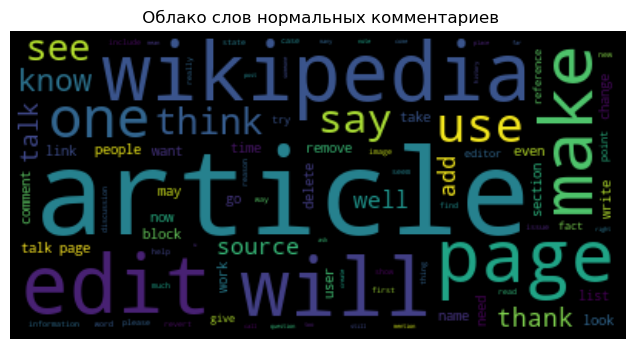

In [26]:
%matplotlib inline
text_normal = data2.loc[data2['toxic'] == 0, 'lemm_text'].sample(10000)
text_normal = " ".join(text_normal)
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")
wc = WordCloud(max_words=1000, stopwords=stopwords, margin=10,
               random_state=12345).generate(text_normal)
# store default colored image
default_colors = wc.to_array()
plt.figure(figsize=(9,4))
plt.title(' Облако слов нормальных комментариев')
plt.imshow(default_colors, interpolation="bilinear")
wc.to_file("word_cloud.png")
plt.axis("off")
plt.show()

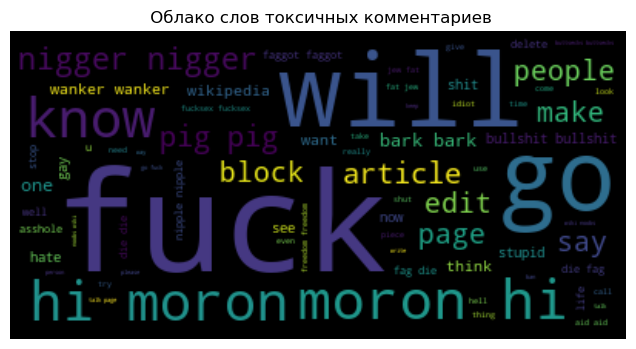

In [27]:
%matplotlib inline
text_toxic = data2.loc[data2['toxic'] == 1, 'lemm_text'].sample(10000)
text_toxic = " ".join(text_toxic)
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")
wc = WordCloud(max_words=1000, stopwords=stopwords, margin=10,
               random_state=12345).generate(text_toxic)
# store default colored image
default_colors = wc.to_array()
plt.figure(figsize=(9,4))
plt.title(' Облако слов токсичных комментариев')
plt.imshow(default_colors, interpolation="bilinear")
wc.to_file("word_cloud.png")
plt.axis("off")
plt.show()

### Train & test

`data2['lemm_text']` - наши будущие фичи, нужно разделить на `train` и `test` до векторизации, чтобы обучить векторайзер `TfidfVectorizer` только на `train`.

In [30]:
target = data2['toxic']
# разделим lem_corpus на train и test до векторизации
features_train, features_test, target_train, target_test = train_test_split(data2['lemm_text'], 
                                                                            target, 
                                                                            test_size=0.25,
                                                                            random_state=12345,
                                                                            stratify=target)
print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (119469,)
Размер тестовой выборки: (39823,)


### TF-IDF


In [31]:
# TF-IDF преобразование (создание)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=True) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\easym\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение 

### Логистическая регрессия

In [32]:
%%time
# Logistic Regression. Подбор параметров. Pipeline
print('\tLogistic Regression (GridSearchCV)')

params={'model__C':[0.01, 0.1, 0.5, 1, 2.5, 5, 10, 20],
        'model__penalty':['l1','l2'],
        'model__class_weight': [None, 'balanced']}

pipeline = Pipeline([
    #('vect', CountVectorizer(min_df=40, ngram_range=(1,2))),
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(random_state=12345))])

grid_logreg = GridSearchCV(pipeline, cv=3, n_jobs=-1, verbose=3, param_grid=params, scoring='f1')
grid_logreg.fit(features_train, target_train)

print(f'F1 на обучающей выборке: {abs(grid_logreg.best_score_)}')
print('Гиперараметры:', grid_logreg.best_params_)


	Logistic Regression (GridSearchCV)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
F1 на обучающей выборке: 0.7666176276861529
Гиперараметры: {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2'}
Wall time: 2min 38s


Как было:

С подбором параметров стало немного получше: (несколько итераций, иначе не выдерживает)
- `'class_weight': 'balanced', 'C': 1.9, 'max_iter': 100`; метрика F1 на обучающей выборке достигла - 0.7500!
- `'class_weight': 'balanced', 'C': 2.5, 'max_iter': 500`; метрика F1 = 0.7524
- Время: Wall time: 1min 36s

Как стало с Pipeline + `TfidfVectorizer` + `GridSearchCV`:

- F1 на обучающей выборке: `0.766617` (стало лучше на сотую долю)
- Гиперараметры: {'C': 10, 'class_weight': None, 'penalty': 'l2'}
- Время Wall time: 2min 9s


### LightGBM Classifier


In [88]:
%%time
# LightGBM. Подбор параметров. Pipeline
print('\tLight GBM Classifier (GridSearchCV)')

parameters = {'model__max_depth': [-1, 10], #2, 5,
              'model__class_weight': [None, 'balanced'],
              'model__n_estimators': [300, 500], #50, 100
              #'learning_rate': [0.1, 0.01]
              #'num_leaves':[10, 30, 50]
             }

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('model', LGBMClassifier(random_state=12345))])

grid_lgbm = GridSearchCV(pipeline, cv=3, n_jobs=-1, verbose=3, param_grid=parameters, scoring='f1')
grid_lgbm.fit(features_train, target_train)

print(f'F1 на обучающей выборке: {abs(grid_lgbm.best_score_)}')
print('Гиперараметры:', grid_lgbm.best_params_)


	Light GBM Classifier (GridSearchCV)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
F1 на обучающей выборке: 0.7679988346239751
Гиперараметры: {'model__class_weight': None, 'model__max_depth': -1, 'model__n_estimators': 500}
Wall time: 8min 44s




Как было с подбором GridSearchCV без Pipeline :
- `'class_weight': None, 'max_depth': -1, 'n_estimators': 300`; метрика f1 = 0.76379
- `'class_weight': None, 'max_depth': -1, 'n_estimators': 500`; метрика f1 = 0.76910
- Время Wall time: 13min 11s



Как стало с Pipeline + TfidfVectorizer + GridSearchCV:

- F1 на обучающей выборке: `0.76799`
- Гиперараметры: {'class_weight': None, 'max_depth': -1, 'n_estimators': 500}
- Время Wall time: 8min 44s

По сравнению с ЛогРег, LightGBM немного точнее, но гораздо дольше.


## Выводы 

Сводка по моделям (при использовании TF-IDF) на обучающей выборке с использованием кросс-валидации:

| Модель                       | Гиперпараметры                                             | Точность результата (F1 score) | 
|:----------------------------:|:----------------------------------------------------------:|:------------------------------:|
| Логистическая регрессия      | `'C': 10, 'class_weight': None, 'penalty': 'l2'`      |0.76661                          | 
| Light GBM                    | `'class_weight': None, 'max_depth': -1, 'n_estimators': 500` | 0.76799                      |
| Random Forest                |    затратно по времени        |      -      |

можно попробовать еще какую-то модель, но не уверена, что с таким объемом данных что-то можно посчитать за обозримое количество времени.

In [91]:
predictions_test = grid_lgbm.predict(features_test)

print(f'F1 на тестовой выборке: ', f1_score(target_test, predictions_test))

F1 на тестовой выборке:  0.7759955752212391
0.7759955752212391


___Результат проверки на тестовой выборке___ показал метрику __`F1 score`__ равной __`0.7759`__, это значит, что модель обучена достаточно точно.

На обучающей стало немного лучше, а на тестовой стало немного хуже. В целом не критично. Но мне кажется, это влияние функции лемматизации с доп. тегами..

# Итоговый вывод 

В ходе проекта были выполнено:

- Преобразование TF-IDF с предварительной очисткой и лемматизацией текста.
- Построено облако самых популярных слов.
- После преобразования было обучено несколько моделей МО:
  - Логистическая регрессия;
  - Модель градиентного бустинга Light GBM;

- Точность каждой модели оценивалась на обучающей выборке в 75% всей выборки с помощью кросс-валидации (сv=3).
- Подбор гиперпараметров каждой модели велся автоматически с помощью  GridSearchCV;
- Результаты сводились в таблицу, по которой выбиралась лучшая модель на обучающей выборке - __Light GBM__. Здесь целевая метрика `F1` равна `0.76799`.
- Результаты на __тестовой выборке__ подтвердили точность: __метрика `F1` равна `0.78`__.


В сравнении с __BERT__ конечно метрики проигрывают существенно:
- лучшая модель у BERT - логистическая регрессия. Метрика `F1` на обучающей выборке равна `0.93923`.
-  метрика F1 на тестовой выборке равна `0.92`.